In [ ]:
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task
!pip install mediapipe

In [ ]:
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
from mediapipe.python.solutions.drawing_utils import _normalized_to_pixel_coordinates
from google.colab import drive
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_dir = "/content/drive/MyDrive/Colab Notebooks/raw_data"

In [ ]:
image_files = []

#for folder in os.listdir(f'{base_dir}/manual_test_photos/'):

for file in os.listdir(f'{base_dir}/manual_test_photos'):
  image_files.append(f'{base_dir}/manual_test_photos/{file}')

In [ ]:

image_files

['/content/drive/MyDrive/Colab Notebooks/raw_data/manual_test_photos/1. noStroke_1.png',
 '/content/drive/MyDrive/Colab Notebooks/raw_data/manual_test_photos/2. stroke_1.png',
 '/content/drive/MyDrive/Colab Notebooks/raw_data/manual_test_photos/3. noStroke_2.png',
 '/content/drive/MyDrive/Colab Notebooks/raw_data/manual_test_photos/5. noStroke_3.png',
 '/content/drive/MyDrive/Colab Notebooks/raw_data/manual_test_photos/4. stroke_2.png',
 '/content/drive/MyDrive/Colab Notebooks/raw_data/manual_test_photos/6. stroke_3.png',
 '/content/drive/MyDrive/Colab Notebooks/raw_data/manual_test_photos/910. stroke_5.png',
 '/content/drive/MyDrive/Colab Notebooks/raw_data/manual_test_photos/9. noStroke_5.png',
 '/content/drive/MyDrive/Colab Notebooks/raw_data/manual_test_photos/8. stroke_4.png',
 '/content/drive/MyDrive/Colab Notebooks/raw_data/manual_test_photos/7. noStroke_4.png',
 '/content/drive/MyDrive/Colab Notebooks/raw_data/manual_test_photos/911. noStroke_6.png',
 '/content/drive/MyDrive/Co

In [ ]:

myorder = [0, 14, 6, 20, 7, 21, 8, 22, 9, 23, 10, 24, 11, 25, 12, 26, 13, 27, 1, 15, 2, 16, 3, 17, 4, 18, 5, 19]
image_files = [image_files[i] for i in myorder]

In [ ]:
image_files

['/content/drive/MyDrive/Colab Notebooks/raw_data/manual_test_photos/1. noStroke_1.png',
 '/content/drive/MyDrive/Colab Notebooks/raw_data/manual_test_photos/2. stroke_1.png',
 '/content/drive/MyDrive/Colab Notebooks/raw_data/manual_test_photos/3. noStroke_2.png',
 '/content/drive/MyDrive/Colab Notebooks/raw_data/manual_test_photos/5. noStroke_3.png',
 '/content/drive/MyDrive/Colab Notebooks/raw_data/manual_test_photos/4. stroke_2.png',
 '/content/drive/MyDrive/Colab Notebooks/raw_data/manual_test_photos/6. stroke_3.png',
 '/content/drive/MyDrive/Colab Notebooks/raw_data/manual_test_photos/910. stroke_5.png',
 '/content/drive/MyDrive/Colab Notebooks/raw_data/manual_test_photos/9. noStroke_5.png',
 '/content/drive/MyDrive/Colab Notebooks/raw_data/manual_test_photos/8. stroke_4.png',
 '/content/drive/MyDrive/Colab Notebooks/raw_data/manual_test_photos/7. noStroke_4.png',
 '/content/drive/MyDrive/Colab Notebooks/raw_data/manual_test_photos/911. noStroke_6.png',
 '/content/drive/MyDrive/Co

In [ ]:
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.python.solutions.drawing_utils import _normalized_to_pixel_coordinates
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
def crop_image(uploaded_img):
  mp_face_detection = mp.solutions.face_detection
  face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)
  mp_drawing = mp.solutions.drawing_utils
  img = cv2.imread(uploaded_img)
#   ipdb.set_trace()
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.copyMakeBorder(img, 100, 100, 50, 50, cv2.BORDER_REFLECT)

  face_detection_results = face_detection.process(img[:,:,::-1])


  if face_detection_results.detections:
    # for face_no, face in enumerate(face_detection_results.detections):
      face_data = face_detection_results.detections[0].location_data
      img_copy = img[:,:,::-1].copy()
      image_rows, image_cols, _ = img_copy.shape
      relative_bounding_box = face_data.relative_bounding_box
      rect_start_point = _normalized_to_pixel_coordinates(
                relative_bounding_box.xmin, relative_bounding_box.ymin, image_cols,
                image_rows)
      rect_end_point = _normalized_to_pixel_coordinates(
          relative_bounding_box.xmin + relative_bounding_box.width,
          relative_bounding_box.ymin + relative_bounding_box.height, image_cols,
          image_rows)


      B, C = rect_start_point
      A, D = rect_end_point
      cropped_img = img_copy[C:D,B:A,:]
      cropped_img = cropped_img[:, :, ::-1].copy()


  else:
    print("Please upload another photo.")

  return cropped_img

In [ ]:
def get_keypoints(crop_img):
    base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
    options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
    detector = vision.FaceLandmarker.create_from_options(options)
    image = mp.Image(image_format=mp.ImageFormat.SRGB, data=crop_img)
    detection_result = detector.detect(image)

    columns = []

    for i in range(1, 479):
        columns.extend([f'x{i}', f'y{i}'])

    test_df = pd.DataFrame(columns=columns)

    all_landmarks = []

    for landmark_coords in detection_result.face_landmarks:
        for landmark in landmark_coords:
            all_landmarks.append(landmark.x)
            all_landmarks.append(landmark.y)

    # Make sure that the landmarks are detected
    if len(all_landmarks) != 956:
        print("Please upload another photo.")

    test_df.loc[len(test_df)] = all_landmarks
    return test_df

In [ ]:
def feature_engineering(df):

    #EYES

    #####INCORRECT FORMULA
    #df['eye_left_area'] = 0.5 * ((df['x71'] * np.abs(df['y56'] - df['y34'])) + (df['x56'] * np.abs(df['y34'] - df['y71'])) + (df['x34'] * np.abs(df['y56'] - df['y71']))))
    #df['eye_right_area'] = 0.5 * ((df['x286'] * np.abs(df['y264'] - df['y301'])) + (df['x264'] * np.abs(df['y301'] - df['y286'])) + (df['x301'] * np.abs(df['y264'] - df['y286']))))

    #####CORRECT FORMULA
    df['eye_left_area'] = np.abs(0.5 * ((df['x71'] * (df['y56'] - df['y34'])) + (df['x56'] * (df['y34'] - df['y71'])) + (df['x34'] * (df['y56'] - df['y71']))))
    df['eye_right_area'] = np.abs(0.5 * ((df['x286'] * (df['y264'] - df['y301'])) + (df['x264'] * (df['y301'] - df['y286'])) + (df['x301'] * (df['y264'] - df['y286']))))

    df['eye_area_diff'] = np.abs(df['eye_left_area'] - df['eye_right_area'])

    #CHEEKS

    df['cheek_left_area'] = ((df['x34']*df['y62']) + (df['x62']*df['y103']) + (df['x103']*df['y134']) + (df['x134']*df['y34'])) - ((df['x62']*df['y34']) + (df['x103']*df['y62'])+ (df['x134']*df['y103']) + (df['x34']*df['y134']))
    df['cheek_right_area'] = ((df['x363']*df['y328']) + (df['x328']*df['y410']) + (df['x410']*df['y264']) + (df['x264']*df['y363'])) - ((df['x328']*df['y363']) + (df['x410']*df['y328'])+ (df['x264']*df['y410']) + (df['x363']*df['y264']))

    df['cheek_area_diff'] = np.abs(df['cheek_left_area'] - df['cheek_right_area'])

    df['cleft_left_area'] = ((df['x103']*df['y62']) + (df['x62']*df['y15']) + (df['x15']*df['y165']) + (df['x165']*df['y103'])) - ((df['x62']*df['y103']) + (df['x15']*df['y62'])+ (df['x165']*df['y15']) + (df['x103']*df['y165']))
    df['cleft_right_area'] = ((df['x165']*df['y15']) + (df['x15']*df['y410']) + (df['x410']*df['y328']) + (df['x328']*df['y165'])) - ((df['x15']*df['y165']) + (df['x410']*df['y15'])+ (df['x328']*df['y410']) + (df['x165']*df['y328']))

    df['cleft_area_diff'] = np.abs(df['cleft_left_area'] - df['cleft_right_area'])

    df['cleft_left_area_2'] = np.abs( 0.5* ((df['x103']*df['y41']) - (df['y103']*df['x41'])) + ((df['x41']*df['y15']) - (df['y41']*df['x15'])) + ((df['x15']*df['y165']) - (df['y15']*df['x165'])) + ((df['x165']*df['y102']) - (df['y165']*df['x102'])) )
    df['cleft_right_area_2'] = np.abs( 0.5* ((df['x165']*df['y15']) - (df['y165']*df['x15'])) + ((df['x15']*df['y312']) - (df['y15']*df['x312'])) + ((df['x312']*df['y328']) - (df['y312']*df['x328'])) + ((df['x328']*df['y103']) - (df['y328']*df['x103'])) )
    df['cleft_area_diff_2'] = np.abs(df['cleft_left_area_2'] - df['cleft_right_area_2'])

    #LIPS

    df['l1_left_lip_x'] = np.abs(df['x62'] - df['x15'])
    df['l1_left_lip_y'] = np.abs(df['y62'] - df['y15'])

    df['l1_right_lip_x'] = np.abs(df['x410'] - df['x15'])
    df['l1_right_lip_y'] = np.abs(df['y410'] - df['y15'])

    df['l1_lip_x'] = np.abs(df['x62'] - df['x410'])
    df['l1_lip_y'] = np.abs(df['y62'] - df['y410'])

    df['left_right_lip_x'] = np.abs(df['l1_left_lip_x'] - df['l1_right_lip_x'])
    df['left_right_lip_y'] = np.abs(df['l1_left_lip_y'] - df['l1_right_lip_y'])

    df['left_angle_lip'] = np.arctan(df['l1_left_lip_y'] / df['l1_left_lip_x'])
    df['right_angle_lip'] = np.arctan(df['l1_right_lip_y'] / df['l1_right_lip_x'])
    df['angle_symmetry'] = np.abs(df['left_angle_lip'] - df['right_angle_lip'])

    #####INCORRECT FORMULA
    # df['lip_top_left_area'] = 0.5 * ((df['x81'] * np.abs(df['y62'] - df['y15'])) + (df['x62'] * np.abs(df['y15'] - df['y81'])) + (df['x15'] * np.abs(df['y62'] - df['y81']))))
    # df['lip_top_right_area'] = 0.5 * ((df['x312'] * np.abs(df['y410'] - df['y15'])) + (df['x62'] * np.abs(df['y15'] - df['y312'])) + (df['x15'] * np.abs(df['y62'] - df['y312']))))
    # df['lip_bot_left_area'] = 0.5 * ((df['x81'] * np.abs(df['y62'] - df['y18'])) + (df['x62'] * np.abs(df['y18'] - df['y81'])) + (df['x18'] * np.abs(df['y62'] - df['y81']))))
    # df['lip_bot_right_area'] = 0.5 * ((df['x410'] * np.abs(df['y18'] - df['y15'])) + (df['x18'] * np.abs(df['y15'] - df['y410'])) + (df['x15'] * np.abs(df['y18'] - df['y410']))))

    #####CORRECT FORMULA
    df['lip_top_left_area'] = np.abs(0.5 * ((df['x81'] * (df['y62'] - df['y15'])) + (df['x62'] * (df['y15'] - df['y81'])) + (df['x15'] * (df['y62'] - df['y81']))))
    df['lip_top_right_area'] = np.abs(0.5 * ((df['x312'] * (df['y410'] - df['y15'])) + (df['x62'] * (df['y15'] - df['y312'])) + (df['x15'] * (df['y62'] - df['y312']))))
    df['lip_bot_left_area'] = np.abs(0.5 * ((df['x81'] * (df['y62'] - df['y18'])) + (df['x62'] * (df['y18'] - df['y81'])) + (df['x18'] * (df['y62'] - df['y81']))))
    df['lip_bot_right_area'] = np.abs(0.5 * ((df['x410'] * (df['y18'] - df['y15'])) + (df['x18'] * (df['y15'] - df['y410'])) + (df['x15'] * (df['y18'] - df['y410']))))

    df['lip_area_diff'] = np.abs(df['lip_top_left_area'] - df['lip_top_right_area']) + np.abs(df['lip_bot_left_area'] - df['lip_bot_right_area'])
    df['l2_lip']=np.sqrt(((df['x62']-df['x410']) **2) + ((df['y62']-df['y410']) **2))

    df['diff_sum'] = df['eye_area_diff'] + df['cheek_area_diff'] + df['cleft_area_diff'] + df['lip_area_diff'] + df['cleft_area_diff_2']

    # features_13_df = df[['cleft_right_area', 'angle_symmetry', 'lip_area_diff' ,'eye_area_diff',
    # 'left_angle_lip' ,'left_right_lip_x', 'lip_top_right_area',
    # 'cheek_left_area' ,'diff_sum', 'lip_top_left_area', 'right_angle_lip', 'l2_lip', 'l1_lip_x']]

    #return features_13_df
    return df[df.columns[-30:]]

In [ ]:
#final_df = pd.DataFrame()

base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)

detector = vision.FaceLandmarker.create_from_options(options)

In [ ]:
new_df.columns

Index(['eye_left_area', 'eye_right_area', 'eye_area_diff', 'cheek_left_area',
       'cheek_right_area', 'cheek_area_diff', 'cleft_left_area',
       'cleft_right_area', 'cleft_area_diff', 'cleft_left_area_2',
       'cleft_right_area_2', 'cleft_area_diff_2', 'l1_left_lip_x',
       'l1_left_lip_y', 'l1_right_lip_x', 'l1_right_lip_y', 'l1_lip_x',
       'l1_lip_y', 'left_right_lip_x', 'left_right_lip_y', 'left_angle_lip',
       'right_angle_lip', 'angle_symmetry', 'lip_top_left_area',
       'lip_top_right_area', 'lip_bot_left_area', 'lip_bot_right_area',
       'lip_area_diff', 'l2_lip', 'diff_sum'],
      dtype='object')

In [ ]:
final_df = pd.DataFrame(columns=new_df.columns)
final_df

,eye_left_area,eye_right_area,eye_area_diff,cheek_left_area,cheek_right_area,cheek_area_diff,cleft_left_area,cleft_right_area,cleft_area_diff,cleft_left_area_2,...,left_angle_lip,right_angle_lip,angle_symmetry,lip_top_left_area,lip_top_right_area,lip_bot_left_area,lip_bot_right_area,lip_area_diff,l2_lip,diff_sum


In [ ]:
new_df

,eye_left_area,eye_right_area,eye_area_diff,cheek_left_area,cheek_right_area,cheek_area_diff,cleft_left_area,cleft_right_area,cleft_area_diff,cleft_left_area_2,...,left_angle_lip,right_angle_lip,angle_symmetry,lip_top_left_area,lip_top_right_area,lip_bot_left_area,lip_bot_right_area,lip_area_diff,l2_lip,diff_sum
0,0.016479,0.062388,0.045909,-0.074385,-0.090199,0.015814,-0.048443,-0.061085,0.012642,0.054226,...,0.459813,0.001542,0.458271,0.0009,0.0033,0.000916,0.038478,0.039962,0.346301,0.148438


In [ ]:
len(image_files)

28

In [ ]:
for image in image_files:
  crop = crop_image(image)
  df = get_keypoints(crop)
  new_df = feature_engineering(df)

  final_df = pd.concat([final_df, new_df], ignore_index=True)

error: ignored

In [ ]:
final_df

,eye_left_area,eye_right_area,eye_area_diff,cheek_left_area,cheek_right_area,cheek_area_diff,cleft_left_area,cleft_right_area,cleft_area_diff,cleft_left_area_2,...,left_angle_lip,right_angle_lip,angle_symmetry,lip_top_left_area,lip_top_right_area,lip_bot_left_area,lip_bot_right_area,lip_area_diff,l2_lip,diff_sum


In [ ]:
final_df.to_csv(r"befaftstroketest.csv", index=False)

In [ ]:
all_x_list = []
all_y_list = []
all_z_list = []
error_images =[]

for num, image in enumerate(image_files):
  img = mp.Image.create_from_file(image)
  detection_result = detector.detect(img)

  x_list=[]
  y_list=[]
  z_list=[]

  try:
    for i in range(len(detection_result.face_landmarks[0])):
      x_list.append(detection_result.face_landmarks[0][i].x)
    #for i in range(len(detection_result.face_landmarks[0])):
      y_list.append(detection_result.face_landmarks[0][i].y)
    #for i in range(len(detection_result.face_landmarks[0])):
      z_list.append(detection_result.face_landmarks[0][i].z)

    all_x_list.append(x_list)
    all_y_list.append(y_list)
    all_z_list.append(z_list)

  except:
    error_images.append(num)
    continue

In [ ]:
x_df = pd.DataFrame(all_x_list, columns =[f"x{x}" for x in range(478)])
y_df = pd.DataFrame(all_y_list, columns =[f"y{x}" for x in range(478)])
z_df = pd.DataFrame(all_z_list, columns =[f"z{x}" for x in range(478)])

In [ ]:
train_df = pd.concat([x_df,y_df,z_df], axis='columns')
train_df.head()

In [ ]:
train_image_files = []

for folder in os.listdir(f'{base_dir}/processed_train/'):

    for file in os.listdir(f'{base_dir}/processed_train/{folder}'):

        train_image_files.append(f'{base_dir}/processed_train/{folder}/{file}')

In [ ]:
len(train_image_files)

1569

In [ ]:
s_image_files = []

#for folder in os.listdir(f'{base_dir}/manual_test_photos/'):

for file in os.listdir(f'{base_dir}/processed_test/Stroke'):
  s_image_files.append(f'{base_dir}/processed_test/Stroke/{file}')

print(len(s_image_files))

112


In [ ]:
len(test_image_files)

200

In [ ]:
test_image_files = []

for folder in os.listdir(f'{base_dir}/processed_test/'):

    for file in os.listdir(f'{base_dir}/processed_test/{folder}'):

        test_image_files.append(f'{base_dir}/processed_test/{folder}/{file}')

In [ ]:
test_img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/raw_data/front.png")

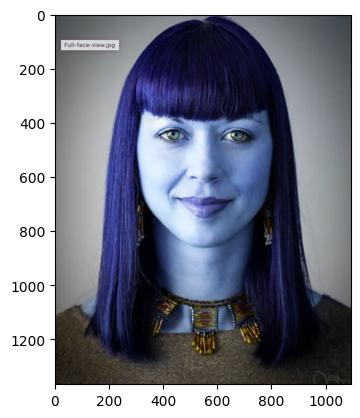

In [ ]:
plt.imshow(test_img)

In [ ]:
def crop_image(uploaded_img):
  mp_face_detection = mp.solutions.face_detection
  face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)
  mp_drawing = mp.solutions.drawing_utils

  img = cv2.imread(uploaded_img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.copyMakeBorder(img, 100, 100, 50, 50, cv2.BORDER_REFLECT)

  face_detection_results = face_detection.process(img[:,:,::-1])
  if face_detection_results.detections:
    for face_no, face in enumerate(face_detection_results.detections):
      face_data = face.location_data
      img_copy = img[:,:,::-1].copy()
      image_rows, image_cols, _ = img_copy.shape
      relative_bounding_box = face_data.relative_bounding_box
      rect_start_point = _normalized_to_pixel_coordinates(
                relative_bounding_box.xmin, relative_bounding_box.ymin, image_cols,
                image_rows)
      rect_end_point = _normalized_to_pixel_coordinates(
          relative_bounding_box.xmin + relative_bounding_box.width,
          relative_bounding_box.ymin + relative_bounding_box.height, image_cols,
          image_rows)

      B, C = rect_start_point
      A, D = rect_end_point
      cropped_img = img_copy[C:D,B:A,:]
      #cropped_img = cropped_img[:, :, ::-1].copy()

  else:
    print("Please upload another photo.")

  return cropped_img

In [ ]:
crop_test = crop_image("/content/drive/MyDrive/Colab Notebooks/raw_data/front.png")

In [ ]:
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image


In [ ]:
image_files[0]

'/content/drive/MyDrive/Colab Notebooks/raw_data/processed_train/Stroke/abc.png'

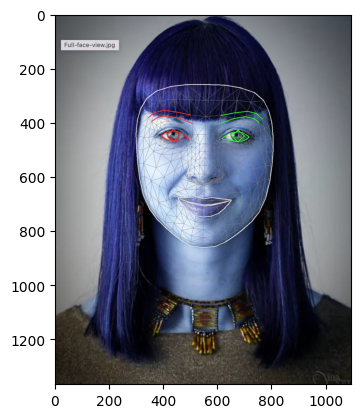

In [ ]:
# STEP 1: Import the necessary modules.
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import matplotlib.pyplot as plt

# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.


#image = mp.Image.create_from_file("/content/drive/MyDrive/Colab Notebooks/raw_data/front.png")

test_img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/raw_data/front.png")
image = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)

# image = cv2.imread("raw_data/noStroke_data/aug_0_10.jpg")
# image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
# image = image[...,::-1]


# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)


# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

In [ ]:
FACE_LANDMARKS_RIGHT_EYE: List[Connection] = [
      Connection(33, 7),
      Connection(7, 163),
      Connection(163, 144),
      Connection(144, 145),
      Connection(145, 153),
      Connection(153, 154),
      Connection(154, 155),
      Connection(155, 133),
      Connection(33, 246),
      Connection(246, 161),
      Connection(161, 160),
      Connection(160, 159),
      Connection(159, 158),
      Connection(158, 157),
      Connection(157, 173),
      Connection(173, 133),
  ]

In [ ]:
FACE_LANDMARKS_RIGHT_EYEBROW: List[Connection] = [
      Connection(46, 53),
      Connection(53, 52),
      Connection(52, 65),
      Connection(65, 55),
      Connection(70, 63),
      Connection(63, 105),
      Connection(105, 66),
      Connection(66, 107),

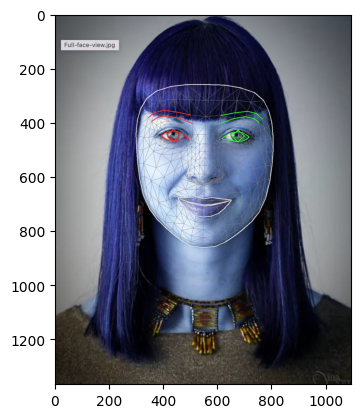

In [ ]:
# STEP 1: Import the necessary modules.
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import matplotlib.pyplot as plt
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path="face_landmarker_v2_with_blendshapes.task")
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)
# STEP 3: Load the input image.
#image = mp.Image.create_from_file(image_files[10])

test_img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/raw_data/front.png")
image = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)

# image = cv2.imread(“raw_data/noStroke_data/aug_0_10.jpg”)
# image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
# image = image[...,::-1]
# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)
# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

In [ ]:
#lips_index = [70, 55, 33, 285, 300, 263, 61, 80, 14, 14, 311, 409, 61, 14, 17, 14, 17, 409, 33, 61, 102, 133, 362, 327, 409, 263, 102, 61, 14, 164, 164, 14, 409, 327]
#lips_index = [316, 271, 304, 324, 313]
#lips_index = [67, 68, 69, 84, 150, 332, 314, 351, 459, 458]
#lips_index = [i for i in range(300, 320)]
#lips_index = [102, 117, 121, 170, 327, 350, 431, 340]
lips_index = [102, 40, 164, 14, 164, 14, 327, 311]

#eyes, eyes, toplip, toplip, botlip, botlip, cheek, cheek, nose, nose



In [ ]:
len(lips_index)

8

In [ ]:
x_list=[]
y_list=[]
z_list=[]
for i in range(len(detection_result.face_landmarks[0])):
  x_list.append(detection_result.face_landmarks[0][i].x)
  y_list.append(detection_result.face_landmarks[0][i].y)
  z_list.append(detection_result.face_landmarks[0][i].z)

In [ ]:
value_x=[]
value_y=[]
value_z=[]
for i in lips_index:
  value_x.append(x_list[i] / z_list[i] )
  value_y.append(y_list[i] / z_list[i] )
  value_z.append(z_list[i])
len(lips_index)

8

In [ ]:
#test_img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/raw_data/front.png")
img=cv2.imread("/content/drive/MyDrive/Colab Notebooks/raw_data/front.png")

In [ ]:
plt.imshow(img)
for i in range(len(value_x)):
  plt.text(value_x[i]*img.shape[1],value_y[i]*img.shape[0], str(i+1), fontsize=8)
# plt.imshow(image)
plt.show()

In [ ]:
len(value_x)

8

In [ ]:
len(lips_index)

8

In [ ]:
len(value_x)

34

In [ ]:
def get_tri_area(x, y):
    area = 0.5 * (x[0] * np.abs(y[1] - y[2]) + x[1] * np.abs(y[2] - y[0]) + x[2]
                  * np.abs(y[0] - y[1]))
    return float(area)

In [ ]:
def get_quad_area(x, y):
    area = 0.5 * ((x[0]*y[1] + x[1]*y[2] + x[2]*y[3] + x[3]*y[0]) - (x[2]*y[0] + x[2]*y[1] + x[3]*y[2] + x[0]*y[3]))
    return float(area)

In [ ]:
def get_poly_area(x, y):
    area = np.abs(0.5 * ((x[0]*y[1] - y[0]*x[1]) + (x[1]*y[2] - y[1]*x[2]) + (x[2]*y[3] - y[2]*x[3] + (x[3]*y[0] - y[3]*x[0])) ))
    return float(area)

In [ ]:
try_x = [-4, -7, 7, 9]
try_y = [9, -8, -5, 5]
get_quad_area(try_x, try_y)

120.5

In [ ]:
print('COMPARE NEW CLEFT')
a = get_poly_area(value_x[0:4], value_y[0:4])
b = get_poly_area(value_x[4:], value_y[4:])
print(a, b)
print(np.abs((a-b)**2))

COMPARE NEW CLEFT
0.0017152771829902491 0.00265843037912461
8.895379513784602e-07


In [ ]:
print('COMPARE EYES')
print(get_tri_area(value_x[:3], value_y[:3]))
print(get_tri_area(value_x[3:6], value_y[3:6]))
print('_______________')
print('COMPARE TOP LIPS')
print(get_tri_area(value_x[6:9], value_y[6:9]))
print(get_tri_area(value_x[9:12], value_y[9:12]))
print('_______________')
print('COMPARE BOTTOM LIPS')
print(get_tri_area(value_x[12:15], value_y[12:15]))
print(get_tri_area(value_x[15:18], value_y[15:18]))
print('_______________')
print('COMPARE CHEEKS')
print(get_quad_area(value_x[18:22], value_y[18:22]))
print(get_quad_area(value_x[22:26], value_y[22:26]))
print('_______________')
print('COMPARE NOSE/LIPS')
print(get_quad_area(value_x[26:30], value_y[26:30]))
print(get_quad_area(value_x[30:], value_y[30:]))
print('_______________')

COMPARE EYES
0.02027023805187511
0.05806793070916427
_______________
COMPARE TOP LIPS
0.02777035701693009
0.08962809639929681
_______________
COMPARE BOTTOM LIPS
0.031281158821421684
0.11124622320593858
_______________
COMPARE CHEEKS
-0.05189986263212498
-0.047243437169221636
_______________
COMPARE NOSE/LIPS
-0.08982571520536098
-0.0561922772610286
_______________
